In [1]:
import os

import pandas as pd
import numpy as np
from numpy.random import seed
from numpy.random import randint
from numpy import mean
from numpy import median
from numpy import percentile
import math 

import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno
from fancyimpute import IterativeImputer
from yellowbrick.features import FeatureImportances
from boruta import BorutaPy
from mlxtend.evaluate import permutation_test

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import GenericUnivariateSelect, f_regression, mutual_info_regression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer

pd.set_option('display.max_columns', 500)

## Load data

About Data: Japan Real Estates Prices

Reference: https://www.kaggle.com/nishiodens/japan-real-estate-transaction-prices

Choose prefecture = Tokyo, which is stored in 13.csv respectively.

In [2]:
file_name_list = [str('{:02.0f}'.format(x)) if x in range(1,10) else str(x) for x in range(1,48)]

In [3]:
ROOT_DIR = 'dataset/trade_prices'
READ_ALL = False

if READ_ALL:

    for file_name in file_name_list:

        read_path = os.path.join(ROOT_DIR, f'{file_name}.csv')

        data = pd.read_csv(read_path)
        
else:
    
    # get data only in precture Tokyo and Kanagawa
    read_path_tokyo = os.path.join(ROOT_DIR, '13.csv')
    #read_path_kanagawa = os.path.join(ROOT_DIR, '14.csv')
    
    df_tokyo = pd.read_csv(read_path_tokyo)
    #df_kanagawa = pd.read_csv(read_path_kanagawa)
    

In [4]:
df_tokyo.head()

,No,Type,Region,MunicipalityCode,Prefecture,Municipality,DistrictName,NearestStation,TimeToNearestStation,MinTimeToNearestStation,MaxTimeToNearestStation,TradePrice,FloorPlan,Area,AreaIsGreaterFlag,UnitPrice,PricePerTsubo,LandShape,Frontage,FrontageIsGreaterFlag,TotalFloorArea,TotalFloorAreaIsGreaterFlag,BuildingYear,PrewarBuilding,Structure,Use,Purpose,Direction,Classification,Breadth,CityPlanning,CoverageRatio,FloorAreaRatio,Period,Year,Quarter,Renovation,Remarks
0,1,"Pre-owned Condominiums, etc.",NaN,13101,Tokyo,Chiyoda Ward,Iidabashi,Iidabashi,4,4.0,4.0,40000000,1LDK,30,0,NaN,NaN,NaN,NaN,False,NaN,0,2013.0,0,RC,House,House,NaN,NaN,NaN,Commercial Zone,80.0,500.0,3rd quarter 2019,2019,3,Not yet,NaN
1,2,"Pre-owned Condominiums, etc.",NaN,13101,Tokyo,Chiyoda Ward,Iidabashi,Iidabashi,4,4.0,4.0,130000000,3LDK,80,0,NaN,NaN,NaN,NaN,False,NaN,0,2007.0,0,RC,NaN,Other,NaN,NaN,NaN,Commercial Zone,80.0,500.0,3rd quarter 2019,2019,3,Done,NaN
2,3,Residential Land(Land and Building),Commercial Area,13101,Tokyo,Chiyoda Ward,Iidabashi,Iidabashi,2,2.0,2.0,400000000,NaN,110,0,NaN,NaN,Trapezoidal Shaped,9.0,False,260.0,0,2018.0,0,S,"Office, Shop",Shop,Northwest,Ward Road,4.0,Commercial Zone,80.0,500.0,2nd quarter 2019,2019,2,NaN,NaN
3,4,Residential Land(Land and Building),Commercial Area,13101,Tokyo,Chiyoda Ward,Iidabashi,Iidabashi,1,1.0,1.0,180000000,NaN,50,0,NaN,NaN,Rectangular Shaped,5.2,False,260.0,0,1976.0,0,RC,"Housing Complex, Office",NaN,Southwest,Tokyo Metropolitan Road,27.0,Commercial Zone,80.0,700.0,2nd quarter 2019,2019,2,NaN,NaN
4,5,"Pre-owned Condominiums, etc.",NaN,13101,Tokyo,Chiyoda Ward,Iidabashi,Iidabashi,4,4.0,4.0,100000000,2LDK,65,0,NaN,NaN,NaN,NaN,False,NaN,0,2007.0,0,RC,House,House,NaN,NaN,NaN,Commercial Zone,80.0,500.0,2nd quarter 2019,2019,2,Done,NaN


In [5]:
df_tokyo.drop('No',axis=1,inplace=True)

## Data understanding

### Basic understanding

In [6]:
print('Total records:', len(df_tokyo))
print('Total variables:', len(df_tokyo.columns))
print('Percentage of null in each column:')
round(df_tokyo.isnull().sum()/len(df_tokyo)*100,2)

Total records: 406575
Total variables: 37
Percentage of null in each column:


Type                            0.00
Region                         45.47
MunicipalityCode                0.00
Prefecture                      0.00
Municipality                    0.00
DistrictName                    0.06
NearestStation                  0.43
TimeToNearestStation            2.54
MinTimeToNearestStation         2.54
MaxTimeToNearestStation         2.58
TradePrice                      0.00
FloorPlan                      56.19
Area                            0.00
AreaIsGreaterFlag               0.00
UnitPrice                      80.45
PricePerTsubo                  80.45
LandShape                      45.57
Frontage                       50.10
FrontageIsGreaterFlag           0.00
TotalFloorArea                 66.45
TotalFloorAreaIsGreaterFlag     0.00
BuildingYear                   22.70
PrewarBuilding                  0.00
Structure                      21.70
Use                            24.08
Purpose                        61.20
Direction                      45.57
C

In [7]:
for column in df_tokyo.columns:
    print(f'Total unique values in {column}:',len(df_tokyo[column].unique()))
    print(column, ':', df_tokyo[column].unique(),'\n')

Total unique values in Type: 5
Type : ['Pre-owned Condominiums, etc.' 'Residential Land(Land and Building)'
 'Residential Land(Land Only)' 'Forest Land' 'Agricultural Land'] 

Total unique values in Region: 5
Region : [nan 'Commercial Area' 'Residential Area' 'Industrial Area'
 'Potential Residential Area'] 

Total unique values in MunicipalityCode: 59
MunicipalityCode : [13101 13102 13103 13104 13105 13106 13107 13108 13109 13110 13111 13112
 13113 13114 13115 13116 13117 13118 13119 13120 13121 13122 13123 13201
 13202 13203 13204 13205 13206 13207 13208 13209 13210 13211 13212 13213
 13214 13215 13218 13219 13220 13221 13222 13223 13224 13225 13227 13228
 13229 13303 13305 13307 13308 13361 13363 13364 13381 13401 13421] 

Total unique values in Prefecture: 1
Prefecture : ['Tokyo'] 

Total unique values in Municipality: 59
Municipality : ['Chiyoda Ward' 'Chuo Ward' 'Minato Ward' 'Shinjuku Ward' 'Bunkyo Ward'
 'Taito Ward' 'Sumida Ward' 'Koto Ward' 'Shinagawa Ward' 'Meguro Ward'
 'Ot

Total unique values in TimeToNearestStation: 35
TimeToNearestStation : ['4' '2' '1' nan '3' '5' '8' '7' '6' '0' '11' '10' '9' '12' '30-60minutes'
 '13' '14' '16' '15' '19' '20' '18' '21' '2H-' '1H30-2H' '17' '22' '29'
 '1H-1H30' '23' '25' '28' '26' '24' '27'] 

Total unique values in MinTimeToNearestStation: 35
MinTimeToNearestStation : [  4.   2.   1.  nan   3.   5.   8.   7.   6.   0.  11.  10.   9.  12.
  30.  13.  14.  16.  15.  19.  20.  18.  21. 120.  90.  17.  22.  29.
  60.  23.  25.  28.  26.  24.  27.] 

Total unique values in MaxTimeToNearestStation: 34
MaxTimeToNearestStation : [  4.   2.   1.  nan   3.   5.   8.   7.   6.   0.  11.  10.   9.  12.
  60.  13.  14.  16.  15.  19.  20.  18.  21. 120.  17.  22.  29.  90.
  23.  25.  28.  26.  24.  27.] 

Total unique values in TradePrice: 504
TradePrice : [   40000000   130000000   400000000   180000000   100000000   120000000
    24000000    13000000   250000000    22000000    69000000    21000000
    81000000    45000000    6

LandShape : [nan 'Trapezoidal Shaped' 'Rectangular Shaped' 'Semi-rectangular Shaped'
 'Semi-trapezoidal Shaped' 'Semi-square Shaped' 'Irregular Shaped'
 'Semi-shaped' 'Flag-shaped etc.' 'Square Shaped'] 

Total unique values in Frontage: 478
Frontage : [ nan  9.   5.2  6.5  6.8 13.   6.4  9.4 15.   7.   6.7 12.  35.   8.
 28.  22.6  3.5 13.1 10.4 10.  14.7  3.  13.5  2.5  4.2 13.2  6.3  5.
  9.5  6.   4.6 19.   7.5  4.5  7.1 10.5 14.6  4.   8.5 16.   5.5 11.5
 15.6 10.8  4.3 11.   6.1 14.8  8.2  9.9 11.7 18.   7.7 12.7  3.8  7.9
  5.7  3.7 18.5 20.3  5.6 11.6 20.   9.3 13.3  6.2 12.5 10.1  8.7 22.2
 16.5 30.   4.7  9.1 25.  11.3  7.2 17.  14.  17.5 10.6  5.8  7.8 14.5
 45.   4.1 26.   9.2 14.4 24.  21.5 31.6 41.5  2.4 31.   9.8  7.3 11.8
 11.1  9.7 22.5 21.   1.9  6.6  8.1 12.6 12.3 23.  32.  22.  40.  20.8
 15.5 11.4  4.8 19.5 27.  23.5  5.1  4.4  3.9 18.3 12.2  5.4  8.6  2.7
  9.6 18.1  6.9 14.2 29.   5.9  7.4 24.5 15.4 10.3 23.6  8.4  8.8 38.5
  3.6 14.1 36.   7.6  8.9 12.9  5.3  4.

Total unique values in Classification: 15
Classification : [nan 'Ward Road' 'Tokyo Metropolitan Road' 'Private Road' 'Town Road'
 'National Highway' 'Road' 'Village Road' 'Agricultural Road'
 'Forest Road' 'City Road' 'Access Road' 'Prefectural Road'
 'Hokkaido Prefectural Road' 'Kyoto/ Osaka Prefectural Road'] 

Total unique values in Breadth: 383
Breadth : [ nan  4.  27.  11.   8.   5.  11.7 17.  16.   9.2  7.   6.6 15.  22.
 36.   6.   3.2  3.  33.   3.1 10.   2.7  5.2  3.5  4.2  5.1 21.9 21.8
  5.8 15.5  9.   6.7  6.5  4.7  4.5  6.4  2.  14.  35.  10.9 11.1 20.
  7.9  5.5  5.4 17.2  8.5 27.2  2.4 43.8 14.5 27.1 27.8  4.6  5.6 12.
 36.8 36.6 18.2 15.8  8.2  6.2 41.9 42.   3.3 12.5  2.8 12.7  3.6 44.
 55.  31.  18.  18.9 13.9  2.3 11.9  2.5  5.3 36.3 45.   9.1 38.   2.9
  7.6 11.4 18.5 18.3 21.6  2.2  8.8  9.4 30.   3.9 11.5 21.  15.7  8.9
  4.1  9.5 10.4  7.8  5.9  6.3 10.8  3.8  9.7 40.   4.3 13.5  3.4  8.1
 12.1 29.   4.8 21.3 25.  20.1 39.9 29.8 18.4 28.5  4.4  3.7  9.3  1.5
 10.

1. Combine columns 'MinTimeToNearestStation' and 'MaxTimeToNearestStation' to form 'MeanTimeToNearestStation'.

2. Columns that can be ignored:
    - Prefecture
    - Municipality
    - TimeToNearestStation
    - UnitPrice
    - PricePerTsubo
    - PrewarBuilding
    - Period
    - Remarks
    - AreaIsGreaterFlag
    - FrontageIsGreaterFlag
    - TotalFloorAreaIsGreaterFlag
    - MinTimeToNearestStation
    - MaxTimeToNearestStation



In [8]:
df_tokyo['MeanTimeToNearestStation'] = df_tokyo['MinTimeToNearestStation']+df_tokyo['MaxTimeToNearestStation']/2

In [9]:
df_tokyo.drop(['Prefecture','Municipality','TimeToNearestStation','UnitPrice',
               'PricePerTsubo','PrewarBuilding','Period','Remarks',
               'AreaIsGreaterFlag','FrontageIsGreaterFlag','TotalFloorAreaIsGreaterFlag',
               'MinTimeToNearestStation', 'MaxTimeToNearestStation'],axis=1,inplace=True)

### Narrow the scope

1. In Type, focus only on 'Pre-owned Condominiums, etc.', 'Residential Land(Land Only)', 'Residential Land(Land and Building)'.

2. In Use, remove the rows without the words 'House' or 'Housing'.

3. In Purpose, focus only on 'House', 'Other' and nan.

In [10]:
len_bf = len(df_tokyo)

df_tokyo = df_tokyo[~((df_tokyo['Type']=='Agricultural Land') | (df_tokyo['Type']=='Forest Land'))]

len_af = len(df_tokyo)

print(f'Removed {len_bf-len_af} rows.')

Removed 540 rows.


In [11]:
len_bf = len(df_tokyo)

df_tokyo['Use'].fillna('Unknown', inplace=True)

df_tokyo = df_tokyo[(df_tokyo.Use.str.contains('House'))|(df_tokyo.Use.str.contains('Housing'))]

len_af = len(df_tokyo)

print(f'Removed {len_bf-len_af} rows.')

Removed 106958 rows.


In [12]:
len_bf = len(df_tokyo)

df_tokyo['Purpose'].fillna('Unknown', inplace=True)

df_tokyo = df_tokyo[df_tokyo['Purpose'].isin(['House', 'Other', 'Unknown'])]

len_af = len(df_tokyo)

print(f'Removed {len_bf-len_af} rows.')

Removed 2339 rows.


In [13]:
for column in df_tokyo.columns:
    print(f'Total unique values in {column}:',len(df_tokyo[column].unique()))
    print(column, ':', df_tokyo[column].unique(),'\n')

Total unique values in Type: 2
Type : ['Pre-owned Condominiums, etc.' 'Residential Land(Land and Building)'] 

Total unique values in Region: 5
Region : [nan 'Commercial Area' 'Residential Area' 'Potential Residential Area'
 'Industrial Area'] 

Total unique values in MunicipalityCode: 59
MunicipalityCode : [13101 13102 13103 13104 13105 13106 13107 13108 13109 13110 13111 13112
 13113 13114 13115 13116 13117 13118 13119 13120 13121 13122 13123 13201
 13202 13203 13204 13205 13206 13207 13208 13209 13210 13211 13212 13213
 13214 13215 13218 13219 13220 13221 13222 13223 13224 13225 13227 13228
 13229 13303 13305 13307 13308 13361 13363 13364 13381 13401 13421] 

Total unique values in DistrictName: 1415
DistrictName : ['Iidabashi' 'Ichibancho' 'Iwamotocho' ... 'Ajiro' 'Shikinejima'
 'Tanzaburo'] 

Total unique values in NearestStation: 653
NearestStation : ['Iidabashi' 'Kudanshita' 'Kojimachi' 'Hanzomon' 'Akihabara' 'Iwamotocho'
 'Kanda (Tokyo)' 'Kodenmacho' 'Shinnihonbashi' 'Bakurocho

Frontage : [ nan  5.2 10.4 10.   3.   4.6  5.  10.5  8.   7.5 13.  15.6 10.8  6.1
  7.7  5.5  6.  11.5 12.7  3.8  6.5  7.  13.3  6.2 16.5  3.7  9.1  4.
 15.  17.   7.8 12.   7.2 14.5 25.   9.9  2.4  9.8 11.8  4.2 11.1  9.
  8.5  5.6  6.6  3.5  4.5 22.  14.  19.  13.5  3.9  5.4 18.1 10.3 23.6
  4.1  6.3  5.8 14.1 36.   3.6  4.7  8.8 35.  11.   9.5 15.1 18.2 23.5
 10.2 12.5  8.7  2.2 23.   7.3  9.2  7.6 18.  12.3  6.9  5.3  4.9  9.6
  8.6 34.  14.6  1.4  2.5  6.8 11.3  8.3 12.6 12.4  9.7 28.   4.8 17.5
  7.1 19.5 18.5 25.5  2.   7.9 18.3  3.1  3.3  5.7 24.   2.7  4.4 19.3
  8.9 11.7 21.  15.5 16.4 13.6  8.4 16.7 11.9 16.  10.1 21.5 20.5 20.4
 12.1  5.1  8.2 10.9 11.4 13.9 13.8 13.2  6.4 26.5 17.6 20.  40.4 30.
 23.2  7.4  9.4 17.3  5.9  6.7  2.9 32.  28.3 11.6  4.3 18.9 12.8 19.8
 14.4 12.2 13.4  3.4 16.8  9.3 14.7 15.3 29.6 16.1 43.5  1.9 16.6  8.1
 10.6  2.3  2.8  2.1  1.8 26.  10.7  3.2 17.1 38.4 23.4  2.6  1.  16.3
 19.4 11.2 14.3 17.8 50.  21.2 18.6 40.  15.2 21.8 22.5 27.  17.9 13.

Classification : [nan 'Tokyo Metropolitan Road' 'Ward Road' 'National Highway'
 'Private Road' 'Road' 'Forest Road' 'City Road' 'Access Road'
 'Prefectural Road' 'Town Road' 'Village Road' 'Hokkaido Prefectural Road'
 'Kyoto/ Osaka Prefectural Road' 'Agricultural Road'] 

Total unique values in Breadth: 314
Breadth : [ nan 27.   8.  11.  22.  36.   6.   3.2  3.   5.2 21.9  9.   4.  15.
  3.1 10.9 20.   5.5  5.4  2.4 14.   6.7  4.5  5.6  7.  16.  10.  42.
  2.7  3.3 55.  18.   5.   2.3 11.9  2.5 45.   3.6  2.2  6.5 33.   8.8
 35.   4.7  9.5  4.6  9.1  7.8  6.3 10.8  3.5  3.8  4.2  3.4  8.1 12.1
 12.  30.  20.1  4.8 18.9  5.3  4.4  2.8  9.3  2.9 10.4 27.6 37.   2.
  2.6  6.4  5.7  3.9  6.9  5.1 16.5 25.   7.2  4.3 16.7 43.   4.9  5.8
  1.2 19.  40.   9.2 11.1 13.   9.9  6.1  6.2  8.2 12.9  4.1 12.4 36.4
  7.5 12.3  7.1 15.1 10.5  1.8  8.3 15.3  3.7  8.4  8.5 44.   1.5  1.6
  7.6 11.5  7.4 17.   7.3 37.2  5.9 15.8  9.4 20.8  6.8  7.7 12.2  1.7
 16.2  1.9  1.  18.3 29.   7.9 38.   2.1 16.3

In [14]:
df_tokyo.head()

,Type,Region,MunicipalityCode,DistrictName,NearestStation,TradePrice,FloorPlan,Area,LandShape,Frontage,TotalFloorArea,BuildingYear,Structure,Use,Purpose,Direction,Classification,Breadth,CityPlanning,CoverageRatio,FloorAreaRatio,Year,Quarter,Renovation,MeanTimeToNearestStation
0,"Pre-owned Condominiums, etc.",NaN,13101,Iidabashi,Iidabashi,40000000,1LDK,30,NaN,NaN,NaN,2013.0,RC,House,House,NaN,NaN,NaN,Commercial Zone,80.0,500.0,2019,3,Not yet,6.0
3,Residential Land(Land and Building),Commercial Area,13101,Iidabashi,Iidabashi,180000000,NaN,50,Rectangular Shaped,5.2,260.0,1976.0,RC,"Housing Complex, Office",Unknown,Southwest,Tokyo Metropolitan Road,27.0,Commercial Zone,80.0,700.0,2019,2,NaN,1.5
4,"Pre-owned Condominiums, etc.",NaN,13101,Iidabashi,Iidabashi,100000000,2LDK,65,NaN,NaN,NaN,2007.0,RC,House,House,NaN,NaN,NaN,Commercial Zone,80.0,500.0,2019,2,Done,6.0
6,"Pre-owned Condominiums, etc.",NaN,13101,Iidabashi,Iidabashi,24000000,1LDK,35,NaN,NaN,NaN,1985.0,SRC,House,House,NaN,NaN,NaN,Commercial Zone,80.0,700.0,2018,4,Not yet,4.5
12,"Pre-owned Condominiums, etc.",NaN,13101,Iidabashi,Iidabashi,81000000,3LDK,70,NaN,NaN,NaN,2007.0,RC,House,Other,NaN,NaN,NaN,Commercial Zone,80.0,500.0,2018,2,Not yet,6.0


## Get general information of each variable

### Collect the columns that are numerical and perform 5-number summary

- Median: The middle value in the sample, also called the 50th percentile or the 2nd quartile.
- 1st Quartile: The 25th percentile.
- 3rd Quartile: The 75th percentile.
- Minimum: The smallest observation in the sample.
- Maximum: The largest observation in the sample.

In [15]:
num_list = ['TradePrice','Area','Frontage','TotalFloorArea','Breadth',
            'CoverageRatio','FloorAreaRatio','MeanTimeToNearestStation']

df_tokyo[num_list].describe()

,TradePrice,Area,Frontage,TotalFloorArea,Breadth,CoverageRatio,FloorAreaRatio,MeanTimeToNearestStation
count,2.967380e+05,296738.000000,115146.000000,124596.000000,124531.000000,292720.000000,292720.000000,287992.000000
mean,4.778639e+07,83.071834,8.398904,142.309986,5.756015,62.970552,276.742758,15.378037
std,1.762832e+08,97.340440,4.851455,196.129451,3.978334,12.997040,159.956699,12.904016
min,1.200000e+03,10.000000,0.900000,10.000000,1.000000,30.000000,50.000000,0.000000
25%,2.100000e+07,40.000000,5.500000,85.000000,4.000000,60.000000,200.000000,7.500000
50%,3.300000e+07,65.000000,7.600000,95.000000,5.000000,60.000000,200.000000,12.000000
75%,4.900000e+07,100.000000,10.000000,110.000000,6.000000,80.000000,400.000000,19.500000
max,6.100000e+10,2000.000000,50.000000,2000.000000,80.000000,80.000000,1300.000000,150.000000


### Collect the columns that are numerical and visualize with boxplot

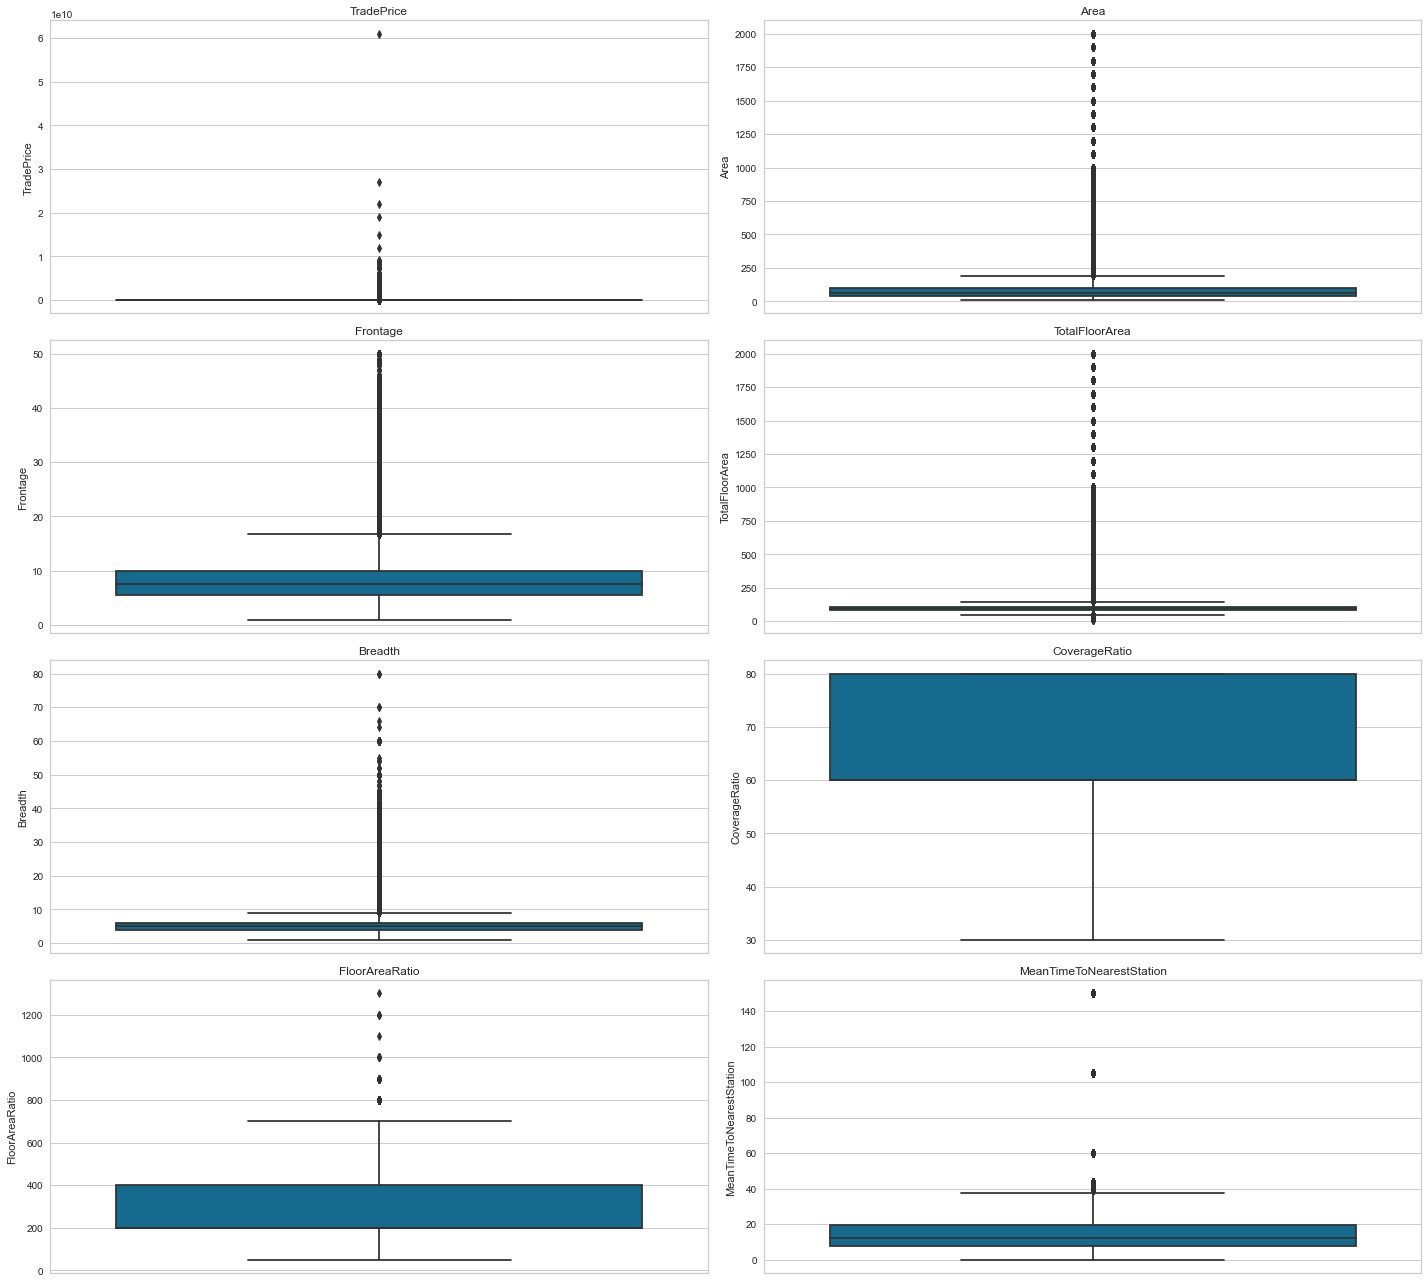

In [16]:
total = len(num_list)
nrows = 4
ncols = math.ceil(total/nrows)
        
fig, axs = plt.subplots(nrows, ncols, figsize=(20, 18))

axs = axs.ravel()

for i in range(total):
    
    sns.boxplot(y=df_tokyo[num_list[i]], ax=axs[i]);
    axs[i].set_title(num_list[i])
    
fig.tight_layout()


plt.show()

### Collect the columns that are numerical and plot the distributions

/Users/khor.eanyee/miniconda3/envs/simfin/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/khor.eanyee/miniconda3/envs/simfin/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


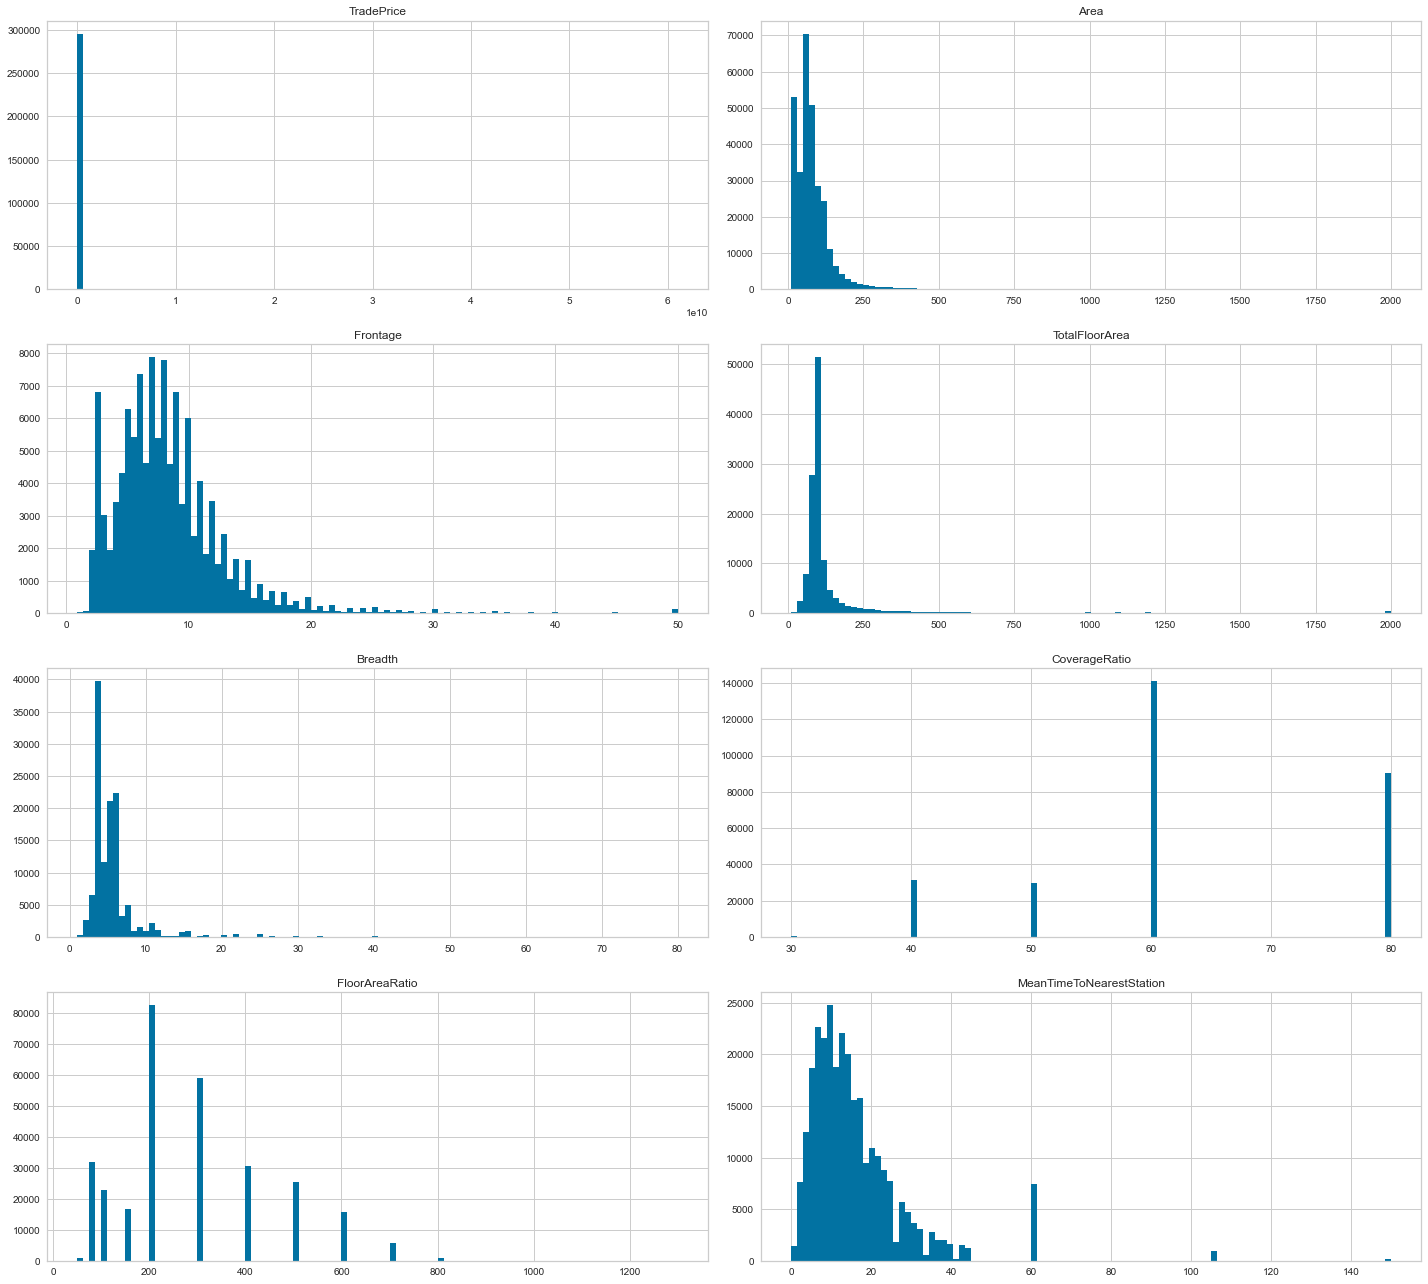

In [17]:
total = len(num_list)
nrows = 4
ncols = math.ceil(total/nrows)
        
fig, axs = plt.subplots(nrows, ncols, figsize=(20, 18))

axs = axs.ravel()

for i in range(total):
    
    axs[i].hist(df_tokyo[num_list[i]], bins=100)
    axs[i].set_title(num_list[i])
    
fig.tight_layout()

### Plot scatter plot between x variables and y variable

In [18]:
def scatter_plot(data, x_variable, y_variable):
    
    sns.lmplot(x=x_variable, y=y_variable, data=data, fit_reg=False)
    plt.title(f'{x_variable} and {y_variable}')
    plt.show()

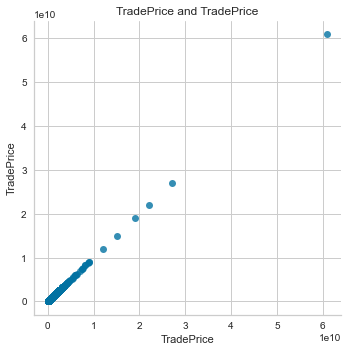

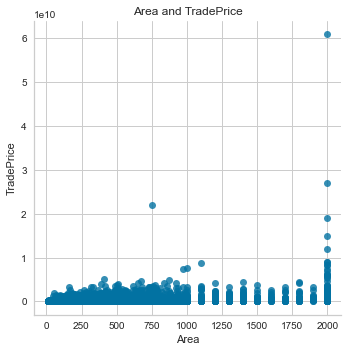

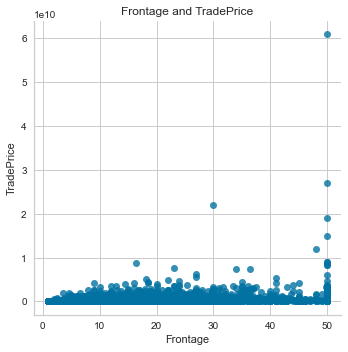

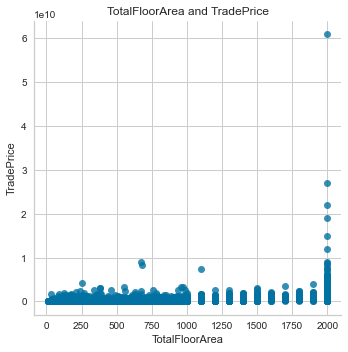

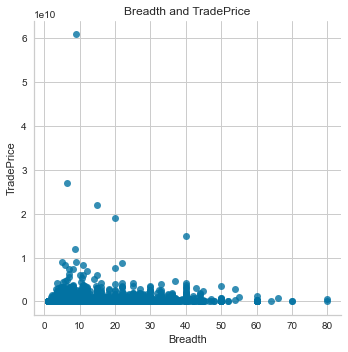

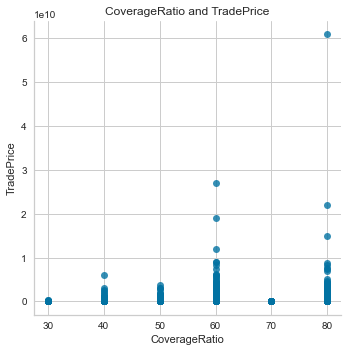

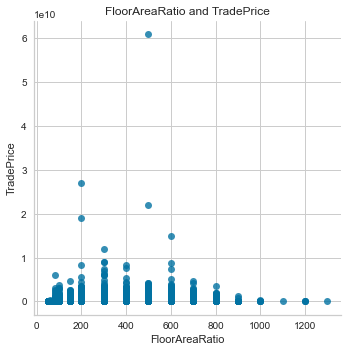

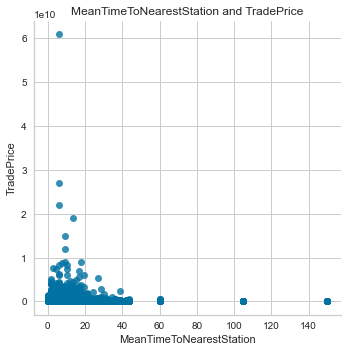

In [19]:
for x_variable in num_list:
    
    scatter_plot(data=df_tokyo, x_variable=x_variable, y_variable='TradePrice')

<b>Conclusion from the scatter plots:</b>

The trade price does not depend only on a single variable.

### Collect the categorical columns and check the frequency of each category

In [20]:
all_var = list(df_tokyo.columns)
cat_list = [x for x in all_var if x not in num_list]
    
for variable in cat_list:
    
    display(df_tokyo[variable].value_counts().rename_axis(variable).reset_index(name='freq'))

,Type,freq
0,"Pre-owned Condominiums, etc.",170694
1,Residential Land(Land and Building),126044


,Region,freq
0,Residential Area,117303
1,Commercial Area,8560
2,Industrial Area,178
3,Potential Residential Area,3


,MunicipalityCode,freq
0,13112,17953
1,13111,17010
2,13120,16528
3,13121,13373
4,13115,12920
5,13119,12296
6,13108,12064
7,13104,11138
8,13109,10522
9,13201,10516


,DistrictName,freq
0,Honcho,1916
1,Kameido,1780
2,Chuo,1749
3,Nishigotanda,1253
4,Nishishinjuku,1226
...,...,...
1409,Nippara,1
1410,Otsumachi,1
1411,Ichigayachoenjimachi,1
1412,Kandamikuracho,1


,NearestStation,freq
0,Hachioji,2487
1,Shinkoiwa,2349
2,Oizumigakuen,2331
3,Kanamachi,1841
4,Omori (Tokyo),1765
...,...,...
647,Ryutsu Center,1
648,Hatonosu,1
649,Yuenchinishi,1
650,Musashikosugi,1


,FloorPlan,freq
0,3LDK,46913
1,1K,46021
2,2LDK,29197
3,1LDK,13050
4,1DK,8852
5,2DK,7641
6,4LDK,5009
7,1R,3107
8,3DK,2628
9,2LDK+S,1050


,LandShape,freq
0,Semi-rectangular Shaped,43479
1,Rectangular Shaped,30799
2,Irregular Shaped,19428
3,Semi-trapezoidal Shaped,9232
4,Semi-square Shaped,6480
5,Flag-shaped etc.,6204
6,Semi-shaped,4873
7,Trapezoidal Shaped,4535
8,Square Shaped,894


,BuildingYear,freq
0,2007.0,12265
1,2006.0,11758
2,2005.0,11277
3,2008.0,11246
4,2009.0,9917
...,...,...
71,1950.0,49
72,1949.0,40
73,1948.0,34
74,2020.0,32


,Structure,freq
0,RC,123560
1,W,104729
2,SRC,52918
3,S,8879
4,LS,2994
5,"RC, W",724
6,"S, W",158
7,"SRC, RC",134
8,B,106
9,"RC, S",98


,Use,freq
0,House,273822
1,Housing Complex,11784
2,"House, Shop",2429
3,"Housing Complex, Shop",1579
4,"House, Office",831
...,...,...
129,"House, Housing Complex, Parking Lot, Other",1
130,"Housing Complex, Office, Workshop, Warehouse, ...",1
131,"House, Workshop, Other",1
132,"House, Workshop, Warehouse, Other",1


,Purpose,freq
0,Unknown,180895
1,House,107623
2,Other,8220


,Direction,freq
0,South,19812
1,North,19478
2,East,18709
3,West,18405
4,Southeast,12485
5,Southwest,12399
6,Northwest,12391
7,Northeast,11437
8,No facing road,776


,Classification,freq
0,Ward Road,49142
1,Private Road,35251
2,City Road,31205
3,Tokyo Metropolitan Road,3839
4,Road,3713
5,Town Road,617
6,National Highway,575
7,Access Road,427
8,Village Road,158
9,Prefectural Road,62


,CityPlanning,freq
0,Category I Exclusively Low-story Residential Zone,64415
1,Commercial Zone,57480
2,Quasi-industrial Zone,43974
3,Category I Exclusively Medium-high Residential...,42434
4,Category I Residential Zone,31423
5,Neighborhood Commercial Zone,29226
6,Category II Exclusively Medium-high Residentia...,7229
7,Category II Residential Zone,6798
8,Industrial Zone,4307
9,Quasi-residential Zone,4244


,Year,freq
0,2013,25542
1,2016,25239
2,2015,25073
3,2014,23823
4,2010,22900
5,2012,22337
6,2017,21755
7,2011,21225
8,2009,20361
9,2018,19557


,Quarter,freq
0,3,75435
1,1,75413
2,4,73227
3,2,72663


,Renovation,freq
0,Not yet,114577
1,Done,40356


## Data Cleaning

Dropping rare features simplifies your model, but obviously gives you fewer features to work with. Before dropping features outright, consider subsetting the part of the dataset that this value is available for and checking its feature importance when it is used to train a model in this subset. If in doing so you disover that the variable is important in the subset it is defined, consider making an effort to retain it.

Reference: https://www.kaggle.com/residentmario/simple-techniques-for-missing-data-imputation

In [21]:
print('Percentage of null in each column:')
round(df_tokyo.isnull().sum()/len(df_tokyo)*100,2)

Percentage of null in each column:


Type                         0.00
Region                      57.52
MunicipalityCode             0.00
DistrictName                 0.05
NearestStation               0.17
TradePrice                   0.00
FloorPlan                   44.23
Area                         0.00
LandShape                   57.56
Frontage                    61.20
TotalFloorArea              58.01
BuildingYear                 2.19
Structure                    0.80
Use                          0.00
Purpose                      0.00
Direction                   57.57
Classification              57.84
Breadth                     58.03
CityPlanning                 0.92
CoverageRatio                1.35
FloorAreaRatio               1.35
Year                         0.00
Quarter                      0.00
Renovation                  47.79
MeanTimeToNearestStation     2.95
dtype: float64

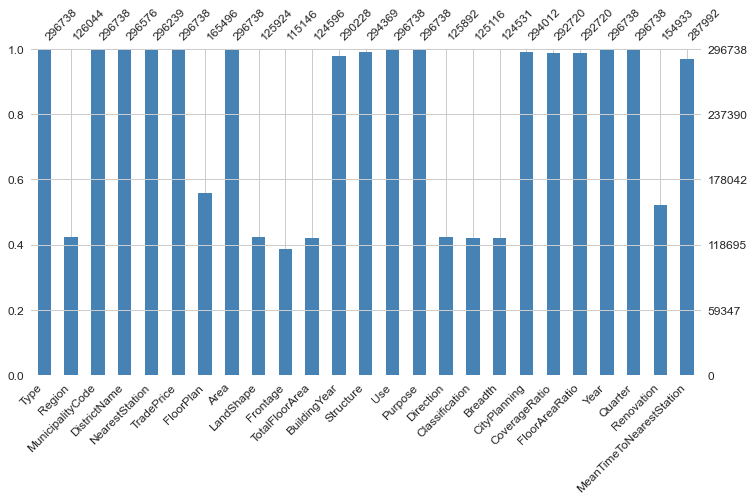

In [22]:
msno.bar(df_tokyo, figsize=(12, 6), fontsize=12, color='steelblue')

plt.show()

### Data Imputation for categorical variables

1. Mode is one of the option.
2. Missing values can be treated as a separate category by itself. We can create another category for the missing values and use them as a different level.
3. If the number of missing values are lesser compared to the number of samples and also the total number of samples is high, we can also choose to remove those rows in our analysis.
4. We can also try to do an imputation based on the values of other variables in the given dataset. We can identify related rows to the given row and then use them for imputation.
5. We can also run a model to predict the missing values using all other variables as inputs.

Reference: https://discuss.analyticsvidhya.com/t/how-to-impute-missing-values-for-a-variable-like-gender/7115

<b>Decision:</b>

1. Since BuildingYear has only 2.19% missing rate, decided to use mode for the imputation.
2. Since it is not our main focus here and for the sake of simplicity, I will just impute unknown as the nan class for other categorical variables.

In [23]:
df_tokyo.loc[df_tokyo['BuildingYear'].isna(), 'BuildingYear'] = df_tokyo['BuildingYear'].mode().values[0]

In [24]:
missing_cat_columns = ['Region', 'NearestStation', 'DistrictName', 'NearestStation', 
                       'FloorPlan', 'LandShape', 'Structure', 'Direction', 'Classification',
                       'CityPlanning', 'Renovation']

for variable in missing_cat_columns:

    df_tokyo[variable].fillna('Unknown', inplace=True)

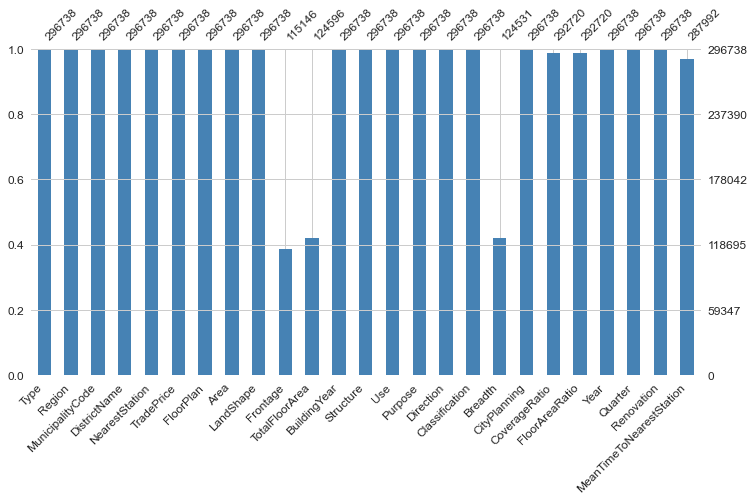

In [25]:
msno.bar(df_tokyo, figsize=(12, 6), fontsize=12, color='steelblue')

plt.show()

In [26]:
df_tokyo_ = df_tokyo.copy()

### Target encode categorical data

In [27]:
class TargetEncoder(BaseEstimator, TransformerMixin):
    """Target encoder.
    
    Replaces categorical column(s) with the mean target value for
    each category.

    """
    
    def __init__(self, cols=None):
        """Target encoder
        
        Parameters
        ----------
        cols : list of str
            Columns to target encode.  Default is to target 
            encode all categorical columns in the DataFrame.
        """
        if isinstance(cols, str):
            self.cols = [cols]
        else:
            self.cols = cols
        
        
    def fit(self, X, y):
        """Fit target encoder to X and y
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values.
            
        Returns
        -------
        self : encoder
            Returns self.
        """
        
        # Encode all categorical cols by default
        if self.cols is None:
            self.cols = [col for col in X]

        # Check columns are in X
        for col in self.cols:
            if col not in X:
                raise ValueError('Column \''+col+'\' not in X')

        # Encode each element of each column
        self.maps = dict() #dict to store map for each column
        for col in self.cols:
            tmap = dict()
            uniques = X[col].unique()
            for unique in uniques:
                tmap[unique] = y[X[col]==unique].mean()
            self.maps[col] = tmap
            
        return self

        
    def transform(self, X, y=None):
        """Perform the target encoding transformation.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
            
        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        Xo = X.copy()
        for col, tmap in self.maps.items():
            vals = np.full(X.shape[0], np.nan)
            for val, mean_target in tmap.items():
                vals[X[col]==val] = mean_target
            Xo[col] = vals
        return Xo
            
            
    def fit_transform(self, X, y=None):
        """Fit and transform the data via target encoding.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values (required!).

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        return self.fit(X, y).transform(X, y)

In [28]:
all_x_var = list(df_tokyo_.columns)
all_x_var.remove('TradePrice')

num_list = ['Area','Frontage','TotalFloorArea','Breadth',
            'CoverageRatio','FloorAreaRatio','MeanTimeToNearestStation']

cat_list = [x for x in all_x_var if x not in num_list]

y_data = df_tokyo_['TradePrice']

num_x_data = df_tokyo_[num_list]
cat_x_data = df_tokyo_[cat_list]

In [29]:
te = TargetEncoder()
encoded_x_data = te.fit_transform(cat_x_data, y_data)

In [30]:
df_tokyo_encoded = pd.merge(encoded_x_data, num_x_data, left_index=True, right_index=True)
df_tokyo_encoded = pd.merge(df_tokyo_encoded, y_data, left_index=True, right_index=True)

### Data Imputation for numerical variables

In [31]:
all_variables = list(df_tokyo_encoded.columns)

In [32]:
# calling the  MICE class 
mice_imputer = IterativeImputer(min_value=0) 
# imputing the missing value with mice imputer 
df_tokyo_output = mice_imputer.fit_transform(df_tokyo_encoded) 

In [33]:
df_tokyo_ = pd.DataFrame(df_tokyo_output, columns=all_variables)

In [34]:
df_tokyo_.head()

,Type,Region,MunicipalityCode,DistrictName,NearestStation,FloorPlan,LandShape,BuildingYear,Structure,Use,Purpose,Direction,Classification,CityPlanning,Year,Quarter,Renovation,Area,Frontage,TotalFloorArea,Breadth,CoverageRatio,FloorAreaRatio,MeanTimeToNearestStation,TradePrice
0,3.069217e+07,3.069217e+07,8.099496e+07,57693750.0,5.092391e+07,3.513731e+07,3.070827e+07,4.814268e+07,4.886580e+07,3.684510e+07,4.820464e+07,3.070091e+07,3.064848e+07,4.913333e+07,5.284229e+07,4.744492e+07,3.146724e+07,30.0,4.117187,806.921348,5.804888,80.0,500.0,6.0,40000000.0
1,7.093609e+07,2.133099e+08,8.099496e+07,57693750.0,5.092391e+07,6.928304e+07,6.260606e+07,3.473787e+07,4.886580e+07,2.253968e+08,4.693176e+07,8.139204e+07,1.726076e+08,4.913333e+07,5.284229e+07,4.566145e+07,6.611977e+07,50.0,5.200000,260.000000,27.000000,80.0,700.0,1.5,180000000.0
2,3.069217e+07,3.069217e+07,8.099496e+07,57693750.0,5.092391e+07,4.177244e+07,3.070827e+07,5.246923e+07,4.886580e+07,3.684510e+07,4.820464e+07,3.070091e+07,3.064848e+07,4.913333e+07,5.284229e+07,4.566145e+07,2.969823e+07,65.0,4.841267,790.235345,5.987665,80.0,500.0,6.0,100000000.0
3,3.069217e+07,3.069217e+07,8.099496e+07,57693750.0,5.092391e+07,3.513731e+07,3.070827e+07,3.658463e+07,3.841949e+07,3.684510e+07,4.820464e+07,3.070091e+07,3.064848e+07,4.913333e+07,5.731352e+07,4.822598e+07,3.146724e+07,35.0,3.969462,886.219926,7.002291,80.0,700.0,4.5,24000000.0
4,3.069217e+07,3.069217e+07,8.099496e+07,57693750.0,5.092391e+07,3.918859e+07,3.070827e+07,5.246923e+07,4.886580e+07,3.684510e+07,6.111792e+07,3.070091e+07,3.064848e+07,4.913333e+07,5.731352e+07,4.566145e+07,3.146724e+07,70.0,5.550573,784.420586,5.681792,80.0,500.0,6.0,81000000.0


In [35]:
num_list = ['TradePrice','Area','Frontage','TotalFloorArea','Breadth',
            'CoverageRatio','FloorAreaRatio','MeanTimeToNearestStation']

df_tokyo_[num_list].describe()

,TradePrice,Area,Frontage,TotalFloorArea,Breadth,CoverageRatio,FloorAreaRatio,MeanTimeToNearestStation
count,2.967380e+05,296738.000000,296738.000000,296738.000000,296738.000000,296738.000000,296738.000000,296738.000000
mean,4.778639e+07,83.071834,6.736511,497.405948,6.326028,62.997870,276.881034,15.269916
std,1.762832e+08,97.340440,3.478423,345.089062,2.927007,12.915762,158.985061,12.756765
min,1.200000e+03,10.000000,0.900000,0.000000,0.000000,30.000000,0.000000,0.000000
25%,2.100000e+07,40.000000,5.000000,100.000000,4.500000,60.000000,200.000000,7.500000
50%,3.300000e+07,65.000000,5.928526,651.557696,6.379861,60.000000,200.000000,12.000000
75%,4.900000e+07,100.000000,7.200000,789.360166,7.556224,80.000000,400.000000,19.500000
max,6.100000e+10,2000.000000,72.056870,2076.019504,80.000000,80.533260,1300.000000,150.000000


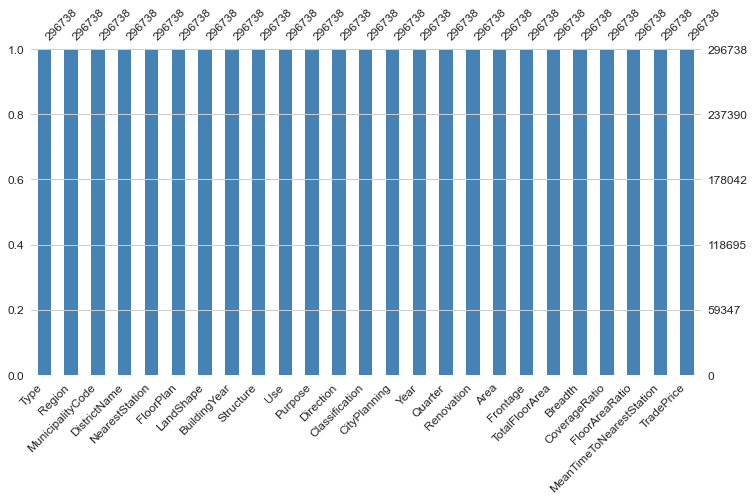

In [36]:
msno.bar(df_tokyo_, figsize=(12, 6), fontsize=12, color='steelblue')

plt.show()

## Feature Selection

### 1. Correlation

Spearman’s Rank Order Correlation is a non-parametric statistical method to quantify the correlation degree between ranked features.

In [37]:
# Compute the correlation matrix
corr = df_tokyo_.corr('spearman')

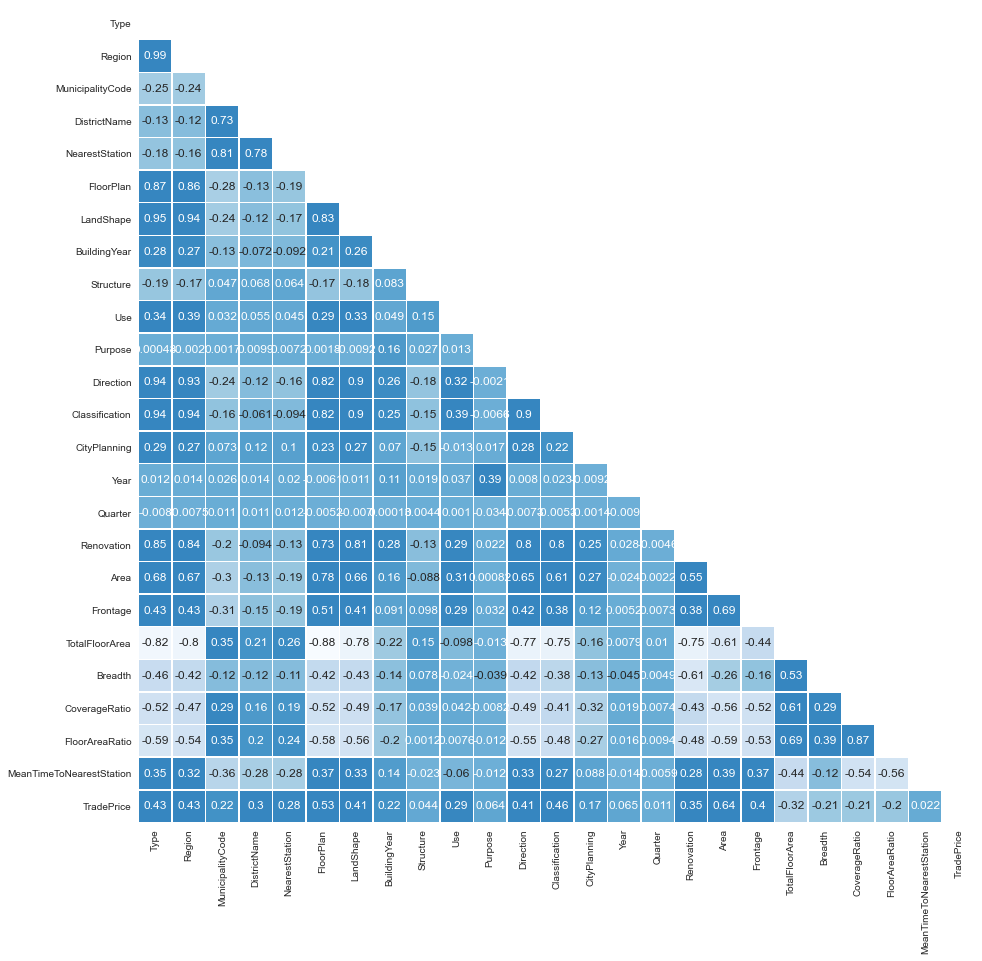

In [38]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='Blues', vmax=.3, center=0, annot=True, 
            linewidths=.5, cbar=False, cbar_kws={"shrink": .5})

plt.show()

In [39]:
tp_related = pd.DataFrame(corr['TradePrice']).reset_index().rename(columns={'index':'variable',
                                                                            'TradePrice':'correlation'})
tp_related['abs_correlation'] = tp_related['correlation'].apply(lambda x: abs(x))

tp_related = tp_related.sort_values('abs_correlation', ascending=False)

In [40]:
tp_related

,variable,correlation,abs_correlation
24,TradePrice,1.000000,1.000000
17,Area,0.635791,0.635791
5,FloorPlan,0.529322,0.529322
12,Classification,0.463632,0.463632
1,Region,0.434789,0.434789
0,Type,0.426027,0.426027
11,Direction,0.413705,0.413705
6,LandShape,0.411048,0.411048
18,Frontage,0.397527,0.397527
16,Renovation,0.353149,0.353149


### 2. Model based

As a simple practice, LinearRegression and DecisionTreeRegressor are used as the models to perform feature selection.

In [41]:
y_data = df_tokyo_['TradePrice']
x_data = df_tokyo_.drop('TradePrice', axis=1)

/Users/khor.eanyee/miniconda3/envs/simfin/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


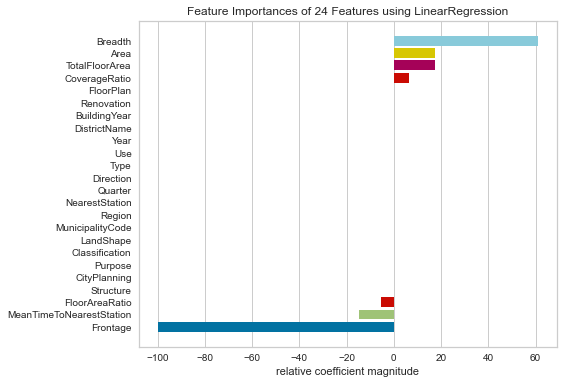

In [42]:
clf = LinearRegression()
viz = FeatureImportances(clf)
viz.fit(x_data, y_data)
viz.poof()

plt.show()

/Users/khor.eanyee/miniconda3/envs/simfin/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


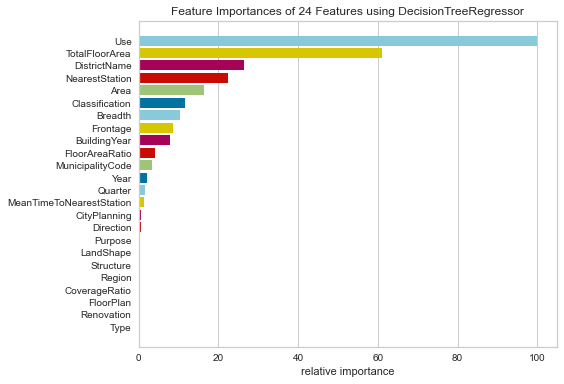

In [43]:
clf = DecisionTreeRegressor()
viz = FeatureImportances(clf)
viz.fit(x_data, y_data)
viz.poof()

plt.show()

### 3. Sklearn univariate feature selection

Sklearn provides both parametric and non-parametric feature selection techniques for both classification and regression problems.

In [44]:
transformer = GenericUnivariateSelect(score_func=f_regression, mode='percentile', param=30)
transformer.fit(x_data, y_data)

result = [list(x_data.columns)[i] for i, x in enumerate(transformer.get_support()) if x]

result

['Region',
 'DistrictName',
 'LandShape',
 'Use',
 'Classification',
 'Area',
 'Frontage']

In [45]:
transformer = GenericUnivariateSelect(score_func=mutual_info_regression, mode='percentile', param=30)
transformer.fit(x_data, y_data)

result = [list(x_data.columns)[i] for i, x in enumerate(transformer.get_support()) if x]

result

['DistrictName',
 'NearestStation',
 'FloorPlan',
 'BuildingYear',
 'Area',
 'Frontage',
 'TotalFloorArea']

### 4. Boruta

Boruta intends to find all-relevant independent variables (including weakly relevant variables). The idea behind Boruta is that the independent variables which are significantly correlated with the dependent variable are considered relevant. 

In [46]:
### Run only once and save into dataframe

classification = RandomForestClassifier(n_estimators=200, n_jobs=-1, max_depth=10)

feature_selector = BorutaPy(classification, n_estimators='auto', random_state=42, verbose=2)
feature_selector.fit(x_data.values, y_data.values)

# check selected features - first 5 features are selected
print(feature_selector.support_)

# check ranking of features
print(feature_selector.ranking_)

result = [list(x_data.columns)[i] for i, x in enumerate(feature_selector.support_) if x]
    
selection_from_boruta = pd.DataFrame(zip(result, list(feature_selector.ranking_)), 
                                     columns=['variable','ranking'])

selection_from_boruta.to_csv('dataset/selection_from_boruta.csv', index=False)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	15
Tentative: 	6
Rejected: 	3
Iteration: 	9 / 100
Confirmed: 	15
Tentative: 	6
Rejected: 	3
Iteration: 	10 / 100
Confirmed: 	15
Tentative: 	6
Rejected: 	3
Iteration: 	11 / 100
Confirmed: 	15
Tentative: 	6
Rejected: 	3
Iteration: 	12 / 100
Confirmed: 	16
Tentative: 	3
Rejected: 	5
Iteration: 	13 / 100
Confirmed: 	16
Tentative: 	3
Rejected: 	5
Iteration: 	14 / 100
Confirmed: 	16
Tentative: 	3
Rejected: 	5
Iteration: 	15 / 100
Confirmed: 	16
Tentative: 	3
Rejected: 	5
Iteration: 	16 / 100
Confirmed: 	16
Tentative: 	3
Rejected: 	5
I

In [56]:
df_boruta = pd.read_csv('dataset/selection_from_boruta.csv')

In [57]:
df_boruta

,variable,ranking
0,MunicipalityCode,2
1,DistrictName,2
2,NearestStation,1
3,FloorPlan,1
4,BuildingYear,1
5,Structure,1
6,Use,2
7,Direction,1
8,Classification,1
9,Year,1


### Idea:

Try two sets of features:

Set 1 (Spearman's correlation):
1. Area
2. FloorPlan
3. Classification
4. Region
5. Type
6. Direction
7. LandShape

Set 2 (from linear regression):
1. Frontage
2. Breadth
3. Area
4. TotalFloorArea
5. MeanTimeToNearestStation
6. FloorPlan
7. FloorAreaRatio

Set 3 (from decision tree):
1. Use
2. TotalFloorArea
3. DistrictName
4. NearestStation
5. Area
6. MunicipalityCode
7. Classification
8. MeanTimeToNearestStation
9. BuildingYear

Set 4 (from sklearn univariate linear regression tests):
1. Region
2. DistrictName
3. LandShape
4. Use
5. Classification
6. Area
7. Frontage

Set 5 (from sklearn mutual information for a continuous target variable):
1. DistrictName
2. NearestStation
3. FloorPlan
4. BuildingYear
5. Area
6. Frontage
7. TotalFloorArea


Set 4 (from boruta): 
1. MunicipalityCode
2. DistrictName
3. NearestStation
4. FloorPlan
5. BuildingYear
6. Structure
7. Use
8. Direction
9. Classification
11. Area
12. Frontage
13. TotalFloorArea
14. Breadth
15. FloorAreaRatio
16. MeanTimeToNearestStation

## Model Training

### Perform Train Test Split

In [58]:
train_data = df_tokyo[df_tokyo['Year']<2019]
test_data = df_tokyo[df_tokyo['Year']==2019]

feature_all = list(df_tokyo.columns)
feature_all.remove('TradePrice')

features_1 = ['Area', 'FloorPlan', 'Classification', 'Region', 'Type', 'Direction', 'LandShape']

features_2 = ['Frontage', 'Breadth', 'Area', 'TotalFloorArea', 
              'MeanTimeToNearestStation', 'FloorPlan', 'FloorAreaRatio']

features_3 = ['Use', 'TotalFloorArea', 'DistrictName', 'NearestStation','Area', 
              'MunicipalityCode', 'Classification', 'MeanTimeToNearestStation', 'BuildingYear']

features_4 = ['Region', 'DistrictName', 'LandShape', 'Use', 'Classification', 'Area', 'Frontage']

features_5 = ['DistrictName', 'NearestStation', 'FloorPlan', 'BuildingYear', 'Area', 'Frontage', 'TotalFloorArea']

features_6 = df_boruta['variable'].tolist()
features_6.remove('Year')

y_train = train_data['TradePrice']
y_test = test_data['TradePrice']

X_train_all = train_data[feature_all]
X_train_1 = train_data[features_1]
X_train_2 = train_data[features_2]
X_train_3 = train_data[features_3]
X_train_4 = train_data[features_4]
X_train_5 = train_data[features_5]
X_train_6 = train_data[features_6]

X_test_all = test_data[feature_all]
X_test_1 = test_data[features_1]
X_test_2 = test_data[features_2]
X_test_3 = test_data[features_3]
X_test_4 = test_data[features_4]
X_test_5 = test_data[features_5]
X_test_6 = test_data[features_6]

## Baseline

For comparison, how well would we do if we just predicted the mean target value for all samples? We’ll use the mean absolute error (MAE) as our performance metric.

In [59]:
test_mae_baseline = mean_absolute_error(y_test, np.full(y_test.shape[0], y_test.mean()))

## Train Linear Regression Model with several feature sets

In [60]:
# Regression model
linear_regression = Pipeline([
    ('encoder', TargetEncoder()),
    ('scaler', StandardScaler()),
    ('imputer', IterativeImputer(min_value=0)),
    ('regressor', LinearRegression())
])

# Cross-validated MAE
mae_scorer = make_scorer(mean_squared_error)
lr_all_scores = cross_val_score(linear_regression, X_train_all, y_train, 
                         cv=5, scoring=mae_scorer)
print('Cross-validated MAE: %0.3f +/- %0.3f'
      % (lr_all_scores.mean(), lr_all_scores.std()))

# MAE on test data
linear_regression.fit(X_train_all, y_train)
y_pred = linear_regression.predict(X_test_all)
test_mae_all = mean_absolute_error(y_test, y_pred)
print('Test MAE: %0.3f' % test_mae_all)

Cross-validated MAE: 32366565883988104.000 +/- 46353592730389800.000
Test MAE: 24568366.981


In [61]:
# Regression model Set 1
linear_regression = Pipeline([
    ('encoder', TargetEncoder()),
    ('scaler', StandardScaler()),
    ('imputer', IterativeImputer(min_value=0)),
    ('regressor', LinearRegression())
])

# Cross-validated MAE
mae_scorer = make_scorer(mean_squared_error)
lr_1_scores = cross_val_score(linear_regression, X_train_1, y_train, 
                         cv=5, scoring=mae_scorer)
print('Cross-validated MAE: %0.3f +/- %0.3f'
      % (lr_1_scores.mean(), lr_1_scores.std()))

# MAE on test data
linear_regression.fit(X_train_1, y_train)
y_pred = linear_regression.predict(X_test_1)
test_mae_1 = mean_absolute_error(y_test, y_pred)
print('Test MAE: %0.3f' % test_mae_1)


Cross-validated MAE: 28929560066178164.000 +/- 35070455979968260.000
Test MAE: 26152995.076


In [62]:
# Regression model Set 2
linear_regression = Pipeline([
    ('encoder', TargetEncoder()),
    ('scaler', StandardScaler()),
    ('imputer', IterativeImputer(min_value=0)),
    ('regressor', LinearRegression())
])

# Cross-validated MAE
mae_scorer = make_scorer(mean_squared_error)
lr_2_scores = cross_val_score(linear_regression, X_train_2, y_train, 
                         cv=5, scoring=mae_scorer)
print('Cross-validated MAE: %0.3f +/- %0.3f'
      % (lr_2_scores.mean(), lr_2_scores.std()))

# MAE on test data
linear_regression.fit(X_train_2, y_train)
y_pred = linear_regression.predict(X_test_2)
test_mae_2 = mean_absolute_error(y_test, y_pred)
print('Test MAE: %0.3f' % test_mae_2)

Cross-validated MAE: 25892116503826652.000 +/- 33683217495695952.000
Test MAE: 23808371.755


In [63]:
# Regression model Set 3
linear_regression = Pipeline([
    ('encoder', TargetEncoder()),
    ('scaler', StandardScaler()),
    ('imputer', IterativeImputer(min_value=0)),
    ('regressor', LinearRegression())
])

# Cross-validated MAE
mae_scorer = make_scorer(mean_squared_error)
lr_3_scores = cross_val_score(linear_regression, X_train_3, y_train, 
                         cv=5, scoring=mae_scorer)
print('Cross-validated MAE: %0.3f +/- %0.3f'
      % (lr_3_scores.mean(), lr_3_scores.std()))

# MAE on test data
linear_regression.fit(X_train_3, y_train)
y_pred = linear_regression.predict(X_test_3)
test_mae_3 = mean_absolute_error(y_test, y_pred)
print('Test MAE: %0.3f' % test_mae_3)

Cross-validated MAE: 32443587484583020.000 +/- 46479081710251064.000
Test MAE: 23645330.140


In [64]:
# Regression model Set 4
linear_regression = Pipeline([
    ('encoder', TargetEncoder()),
    ('scaler', StandardScaler()),
    ('imputer', IterativeImputer(min_value=0)),
    ('regressor', LinearRegression())
])

# Cross-validated MAE
mae_scorer = make_scorer(mean_squared_error)
lr_4_scores = cross_val_score(linear_regression, X_train_4, y_train, 
                         cv=5, scoring=mae_scorer)
print('Cross-validated MAE: %0.3f +/- %0.3f'
      % (lr_4_scores.mean(), lr_4_scores.std()))

# MAE on test data
linear_regression.fit(X_train_4, y_train)
y_pred = linear_regression.predict(X_test_4)
test_mae_4 = mean_absolute_error(y_test, y_pred)
print('Test MAE: %0.3f' % test_mae_4)

Cross-validated MAE: 28855808474358112.000 +/- 35191853054245088.000
Test MAE: 28377659.935


In [65]:
# Regression model Set 5
linear_regression = Pipeline([
    ('encoder', TargetEncoder()),
    ('scaler', StandardScaler()),
    ('imputer', IterativeImputer(min_value=0)),
    ('regressor', LinearRegression())
])

# Cross-validated MAE
mae_scorer = make_scorer(mean_squared_error)
lr_5_scores = cross_val_score(linear_regression, X_train_5, y_train, 
                         cv=5, scoring=mae_scorer)
print('Cross-validated MAE: %0.3f +/- %0.3f'
      % (lr_5_scores.mean(), lr_5_scores.std()))

# MAE on test data
linear_regression.fit(X_train_5, y_train)
y_pred = linear_regression.predict(X_test_5)
test_mae_5 = mean_absolute_error(y_test, y_pred)
print('Test MAE: %0.3f' % test_mae_5)

Cross-validated MAE: 37492612598155136.000 +/- 57020596958746376.000
Test MAE: 23693139.027


In [66]:
# Regression model Set 6
linear_regression = Pipeline([
    ('encoder', TargetEncoder()),
    ('scaler', StandardScaler()),
    ('imputer', IterativeImputer(min_value=0)),
    ('regressor', LinearRegression())
])

# Cross-validated MAE
mae_scorer = make_scorer(mean_squared_error)
lr_6_scores = cross_val_score(linear_regression, X_train_6, y_train, 
                         cv=5, scoring=mae_scorer)
print('Cross-validated MAE: %0.3f +/- %0.3f'
      % (lr_6_scores.mean(), lr_6_scores.std()))

# MAE on test data
linear_regression.fit(X_train_6, y_train)
y_pred = linear_regression.predict(X_test_6)
test_mae_6 = mean_absolute_error(y_test, y_pred)
print('Test MAE: %0.3f' % test_mae_6)

Cross-validated MAE: 32660154961693944.000 +/- 46916097247434936.000
Test MAE: 24396789.254


## Evaluation

### (Bootstrapped) Confidence Interval

Confidence intervals are a way of quantifying the uncertainty of an estimate.

In [67]:
# bootstrap confidence intervals

def get_ci(cv_scores, sample_size=1000):
    
#     # seed the random number generator
#     seed(1)
    
    ori_size = len(cv_scores)
    
    # bootstrap
    scores = list()
    
    for _ in range(sample_size):
        # bootstrap sample
        indices = randint(0, ori_size-1, sample_size)
        sample = cv_scores[indices]
        # calculate and store statistic
        statistic = mean(sample)
        scores.append(statistic)
        
    # calculate the central tendency 
    print('50th percentile (median) = %.3f' % median(scores))

    # calculate 95% confidence intervals (100 - alpha)
    alpha = 5.0

    # calculate lower percentile (e.g. 2.5)
    lower_p = alpha / 2.0
    # retrieve observation at lower percentile
    lower = percentile(scores, lower_p)
    print('%.1fth percentile = %.3f' % (lower_p, lower))

    # calculate upper percentile (e.g. 97.5)
    upper_p = (100 - alpha) + (alpha / 2.0)
    # retrieve observation at upper percentile
    upper = percentile(scores, upper_p)
    print('%.1fth percentile = %.3f' % (upper_p, upper))
    
    return scores, lower, upper

In [68]:
print('Linear Regression with all features:')

lr_all_boot_scores, lr_all_boot_lower, lr_all_boot_upper = get_ci(lr_all_scores, sample_size=1000)

print('Linear Regression with feature set 1:')

lr_1_boot_scores, lr_1_boot_lower, lr_1_boot_upper = get_ci(lr_1_scores, sample_size=1000)

print('\nLinear Regression with feature set 2:')

lr_2_boot_scores, lr_2_boot_lower, lr_2_boot_upper = get_ci(lr_2_scores, sample_size=1000)

print('\nLinear Regression with feature set 3:')

lr_3_boot_scores, lr_3_boot_lower, lr_3_boot_upper = get_ci(lr_3_scores, sample_size=1000)

print('\nLinear Regression with feature set 4:')

lr_4_boot_scores, lr_4_boot_lower, lr_4_boot_upper = get_ci(lr_4_scores, sample_size=1000)

print('\nLinear Regression with feature set 5:')

lr_5_boot_scores, lr_5_boot_lower, lr_5_boot_upper = get_ci(lr_5_scores, sample_size=1000)

print('\nLinear Regression with feature set 6:')

lr_6_boot_scores, lr_6_boot_lower, lr_6_boot_upper = get_ci(lr_6_scores, sample_size=1000)

Linear Regression with all features:
50th percentile (median) = 37949332293897688.000
2.5th percentile = 34876636050615472.000
97.5th percentile = 40949228120403760.000
Linear Regression with feature set 1:
50th percentile (median) = 32332994338151196.000
2.5th percentile = 29981023979079896.000
97.5th percentile = 34785972891612752.000

Linear Regression with feature set 2:
50th percentile (median) = 29773239732200456.000
2.5th percentile = 27498158730446948.000
97.5th percentile = 32037668122385412.000

Linear Regression with feature set 3:
50th percentile (median) = 38171392730513144.000
2.5th percentile = 34918239582504440.000
97.5th percentile = 41225239962851216.000

Linear Regression with feature set 4:
50th percentile (median) = 32690910092348816.000
2.5th percentile = 30420583118917460.000
97.5th percentile = 35116139661623988.000

Linear Regression with feature set 5:
50th percentile (median) = 44296207922779744.000
2.5th percentile = 40647724814138920.000
97.5th percentile =

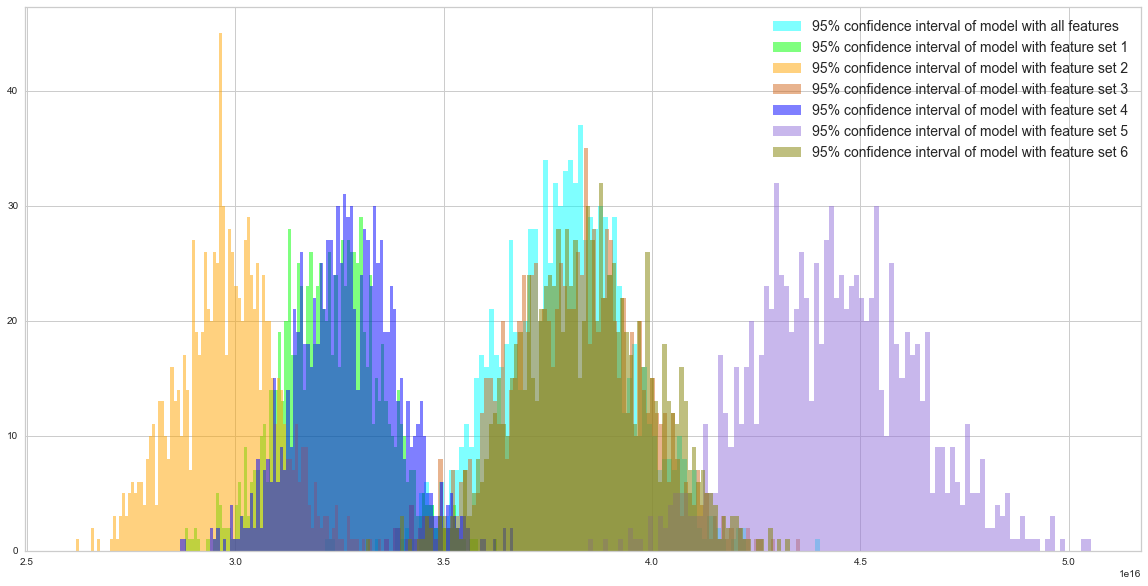

In [69]:
plt.figure(figsize=(20,10))

plt.hist(lr_all_boot_scores, 100, alpha=0.5, color='aqua', 
         label='95% confidence interval of model with all features')

plt.hist(lr_1_boot_scores, 100, alpha=0.5, color='lime',
         label='95% confidence interval of model with feature set 1')

plt.hist(lr_2_boot_scores, 100, alpha=0.5, color='orange', 
         label='95% confidence interval of model with feature set 2')

plt.hist(lr_3_boot_scores, 100, alpha=0.5, color='chocolate',
         label='95% confidence interval of model with feature set 3')

plt.hist(lr_4_boot_scores, 100, alpha=0.5, color='blue',
         label='95% confidence interval of model with feature set 4')

plt.hist(lr_5_boot_scores, 100, alpha=0.5, color='mediumpurple',
         label='95% confidence interval of model with feature set 5')

plt.hist(lr_6_boot_scores, 100, alpha=0.5, color='olive',
         label='95% confidence interval of model with feature set 6')

plt.legend(fontsize=14)

plt.show()

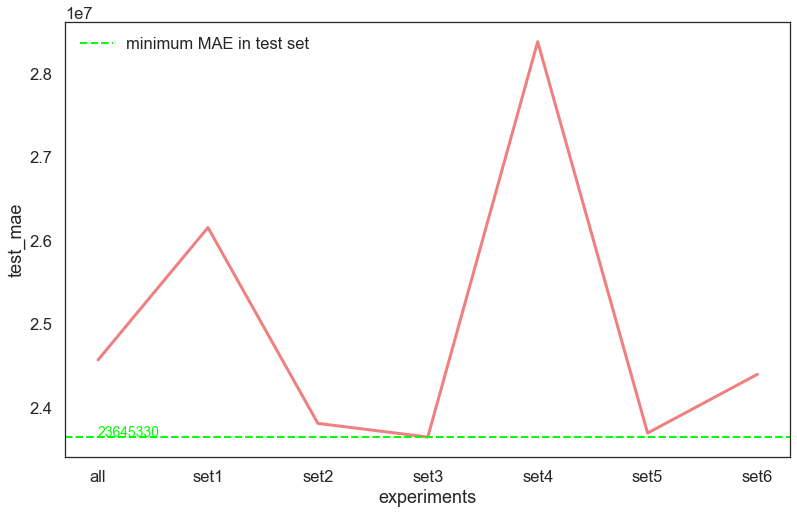

In [70]:
experiments = ['all', 'set1', 'set2', 'set3', 'set4', 'set5', 'set6']

sns.set(font_scale = 1.5)
sns.set_style('white')

plt.figure(figsize=(13,8))

test_maes = [test_mae_all, test_mae_1, test_mae_2, test_mae_3, test_mae_4, test_mae_5, test_mae_6]

min_mae = int(min(test_maes))

df_test_maes = pd.DataFrame(list(zip(experiments, test_maes)), 
                            columns =['experiments', 'test_mae'])

sns.lineplot(x='experiments', y='test_mae', data=df_test_maes, linewidth = 3, 
             sort=False, color='lightcoral')

plt.axhline(y=min_mae, label='minimum MAE in test set', color='lime', linewidth = 2, linestyle='--')
plt.text(0, min_mae, str(min_mae), label='min mae', color='lime', fontsize=14)

plt.legend()

plt.show()

<b>Conclusion:</b>

It is interesting that feature set 2 achieves lower MAE in cross validation process but feature set 3 has lowest MAE (followed by feature 5) with test data.

It may due to the distribution of test data (2019 data) is different to train data (2005~2018 data).

Let's see if this is a valid assumption.

In [ ]:
## Run only once and save into dataframe

import random
from sklearn.utils import resample
import statistics
from numpy import mean, std

random.seed(1)

year_list = list(np.sort(df_tokyo['Year'].unique()))

df_interested = df_tokyo[['Year','TradePrice']]

outside_dict = {}

for year in year_list:

    mean_list = []
    
    total_len = len(df_interested[df_interested['Year']==year])
    total_sample = max(6000, int(total_len/2))

    for i in range(2000):

        boot = resample(df_tokyo['TradePrice'], replace=True, n_samples=total_sample)
        boot_mean = statistics.mean(boot)
        mean_list.append(boot_mean)


    outside_dict[f'{year}'] = mean_list

bootstrap_trade_price = pd.DataFrame.from_dict(outside_dict)
bootstrap_trade_price.to_csv('dataset/tokyo_bootstrap_trade_price.csv', index=False)

In [77]:
bootstrap_trade_price = pd.read_csv('dataset/tokyo_bootstrap_trade_price.csv')

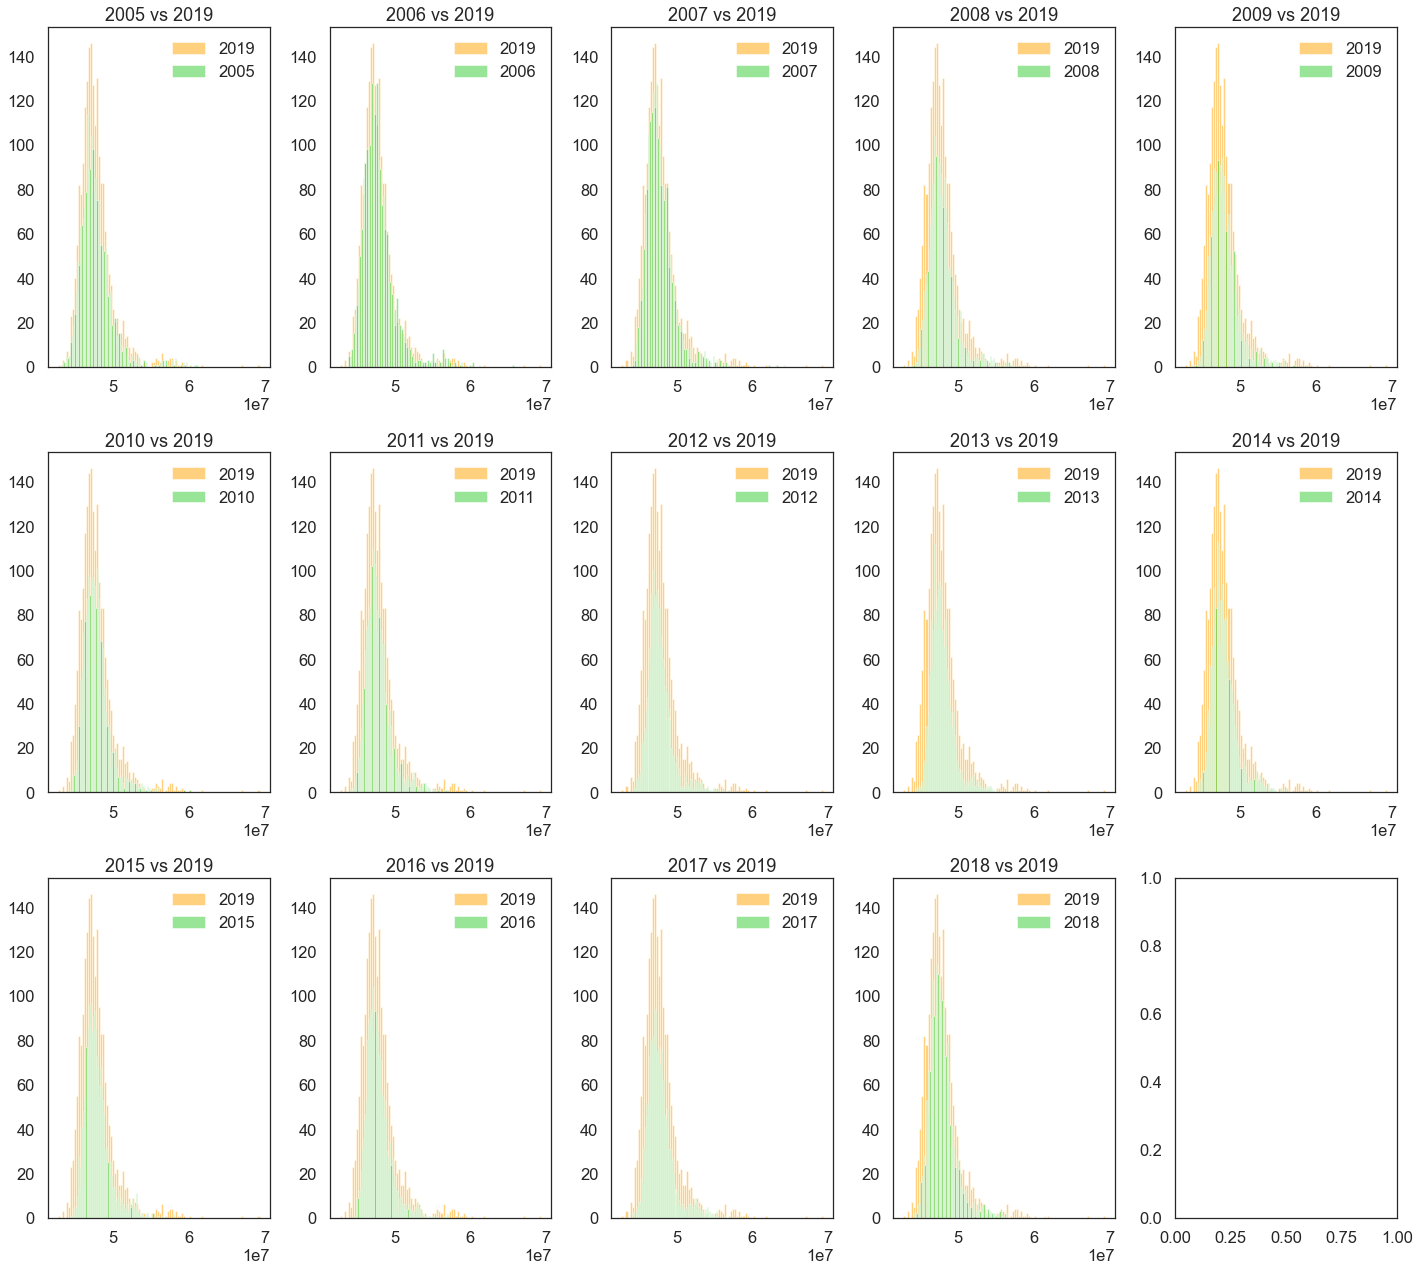

In [84]:
year_list = list(np.sort(df_tokyo['Year'].unique()))
year_list.remove(2019)

total = 2019-2005
ncols = 5
nrows = math.ceil(total/ncols)

fig, axs = plt.subplots(nrows, ncols, figsize=(20, 18))

axs = axs.ravel()
i=0

for year in year_list:
        
        
    axs[i].hist(bootstrap_trade_price['2019'], bins=100, alpha=0.5, color='orange', label='2019')
    axs[i].hist(bootstrap_trade_price[f'{year}'], bins=100, alpha=0.5, color='limegreen', label=f'{year}')

    axs[i].set_title(f'{year} vs 2019')

    axs[i].legend()

    i+=1
    
fig.tight_layout()

In [75]:
from mlxtend.evaluate import permutation_test

year_list = list(np.sort(df_tokyo['Year'].unique()))
year_list.remove(2019)

for year in year_list:

    test_year_price = df_tokyo[df_tokyo['Year']==2019]['TradePrice']
    train_year_price = df_tokyo[df_tokyo['Year']==year]['TradePrice']
    
    p_value = permutation_test(test_year_price, train_year_price,
                               method='approximate',
                               num_rounds=5000,
                               seed=0)
    
    print('p=%.3f' %(p_value))
    
    # interpret
    alpha = 0.05
    if p_value > alpha:
        print(f'The data from {year} and 2019 have the same distributions (fail to reject H0).')
    else:
        print(f'The data from {year} and 2019 have the different distributions (reject H0).')

p=0.961
The data from 2005 and 2019 have the same distributions (fail to reject H0).
p=0.837
The data from 2006 and 2019 have the same distributions (fail to reject H0).
p=0.007
The data from 2007 and 2019 have the different distributions (reject H0).
p=0.005
The data from 2008 and 2019 have the different distributions (reject H0).
p=0.000
The data from 2009 and 2019 have the different distributions (reject H0).
p=0.000
The data from 2010 and 2019 have the different distributions (reject H0).
p=0.003
The data from 2011 and 2019 have the different distributions (reject H0).
p=0.000
The data from 2012 and 2019 have the different distributions (reject H0).
p=0.000
The data from 2013 and 2019 have the different distributions (reject H0).
p=0.000
The data from 2014 and 2019 have the different distributions (reject H0).
p=0.000
The data from 2015 and 2019 have the different distributions (reject H0).
p=0.000
The data from 2016 and 2019 have the different distributions (reject H0).
p=0.156
Th

<b>Conclusion:</b>
    
From the permutation test, it seems that only 2005, 2006, and 2017 data have similar distribution to 2019 data. 

This explains the reason of having contradictory result from cross validation and test data.